## Overview
This Calgary HTTP dataset contains approximately one year's worth of HTTP requests to the University of Calgary's Computer Science web server. 

### Data Loading and Cleaning

In [3]:
# Import the gzip module to work with .gz compressed files
import gzip
# Open the gzip-compressed log file in text mode ('rt')
with gzip.open('calgary_access_log.gz', 'rt', encoding='utf-8', errors='ignore') as f:
    # Read all lines from the file and store them in a list called 'lines'
    lines = f.readlines()

In [4]:
# Show first 5 log lines
for line in lines[:5]:
    print(line.strip())

local - - [24/Oct/1994:13:41:41 -0600] "GET index.html HTTP/1.0" 200 150
local - - [24/Oct/1994:13:41:41 -0600] "GET 1.gif HTTP/1.0" 200 1210
local - - [24/Oct/1994:13:43:13 -0600] "GET index.html HTTP/1.0" 200 3185
local - - [24/Oct/1994:13:43:14 -0600] "GET 2.gif HTTP/1.0" 200 2555
local - - [24/Oct/1994:13:43:15 -0600] "GET 3.gif HTTP/1.0" 200 36403


In [5]:
# Import the 're' module to use regular expressions
import re

# Define a regular expression pattern to match log entries in Common Log Format (CLF)
# The pattern captures the following groups:
# 1. Host/IP address
# 2. Identity (usually '-')
# 3. User ID (usually '-')
# 4. Timestamp (inside square brackets)
# 5. HTTP method (e.g., GET, POST)
# 6. Requested resource/path
# 7. Protocol (e.g., HTTP/1.1)
# 8. Status code (e.g., 200, 404)
# 9. Size of the response (in bytes or '-')
log_pattern = re.compile(
    r'(\S+) (\S+) (\S+) \[(.*?)\] "(\S+) (.*?) (\S+)" (\d{3}) (\S+)'
)

# Initialize an empty list to store successfully parsed log entries
parsed_logs = []

# Loop through each line in the previously loaded 'lines' list
for line in lines:
    # Try to match the line with the regular expression pattern
    match = log_pattern.match(line)
    if match:
        # If a match is found, append the tuple of matched groups to 'parsed_logs'
        parsed_logs.append(match.groups())

# Print the number of valid log entries successfully parsed
print(f"Successfully parsed {len(parsed_logs)} valid log entries.")

Successfully parsed 723275 valid log entries.


In [6]:
# Import the pandas library for data manipulation and analysis
import pandas as pd

# Define column names for the DataFrame that correspond to the parsed log entry fields
columns = [
    'host',       # IP address or hostname of the client
    'rfc931',     # Remote logname (usually '-')
    'authuser',   # Authenticated username (usually '-')
    'timestamp',  # Date and time of the request
    'method',     # HTTP method (e.g., GET, POST)
    'request',    # Requested resource (e.g., /index.html)
    'protocol',   # Protocol version (e.g., HTTP/1.1)
    'status',     # HTTP status code (e.g., 200, 404)
    'bytes'       # Size of the response in bytes (or '-' if unknown)
]

# Create a DataFrame from the parsed logs using the defined column names
df = pd.DataFrame(parsed_logs, columns=columns)

# Confirm that the DataFrame was created successfully
print("DataFrame created.")

# Display the first few rows of the DataFrame to verify the structure and content
df.head()

DataFrame created.


,host,rfc931,authuser,timestamp,method,request,protocol,status,bytes
0,local,-,-,24/Oct/1994:13:41:41 -0600,GET,index.html,HTTP/1.0,200,150
1,local,-,-,24/Oct/1994:13:41:41 -0600,GET,1.gif,HTTP/1.0,200,1210
2,local,-,-,24/Oct/1994:13:43:13 -0600,GET,index.html,HTTP/1.0,200,3185
3,local,-,-,24/Oct/1994:13:43:14 -0600,GET,2.gif,HTTP/1.0,200,2555
4,local,-,-,24/Oct/1994:13:43:15 -0600,GET,3.gif,HTTP/1.0,200,36403


In [7]:
# Timestamp conversion
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce', utc=True)

# Bytes: Replace '-' with 0, then convert
df['bytes'] = df['bytes'].replace('-', 0).astype(int)

# Status code to int
df['status'] = df['status'].astype(int)

print("Converted timestamp, bytes, and status fields.")
df.dtypes

Converted timestamp, bytes, and status fields.


host                      object
rfc931                    object
authuser                  object
timestamp    datetime64[ns, UTC]
method                    object
request                   object
protocol                  object
status                     int32
bytes                      int32
dtype: object

In [8]:
df.head()

,host,rfc931,authuser,timestamp,method,request,protocol,status,bytes
0,local,-,-,1994-10-24 19:41:41+00:00,GET,index.html,HTTP/1.0,200,150
1,local,-,-,1994-10-24 19:41:41+00:00,GET,1.gif,HTTP/1.0,200,1210
2,local,-,-,1994-10-24 19:43:13+00:00,GET,index.html,HTTP/1.0,200,3185
3,local,-,-,1994-10-24 19:43:14+00:00,GET,2.gif,HTTP/1.0,200,2555
4,local,-,-,1994-10-24 19:43:15+00:00,GET,3.gif,HTTP/1.0,200,36403


In [9]:
#Extract File Extensions
df['file_extension'] = df['request'].str.extract(r'\.([a-zA-Z0-9]+)$')

In [10]:
df.head()

,host,rfc931,authuser,timestamp,method,request,protocol,status,bytes,file_extension
0,local,-,-,1994-10-24 19:41:41+00:00,GET,index.html,HTTP/1.0,200,150,html
1,local,-,-,1994-10-24 19:41:41+00:00,GET,1.gif,HTTP/1.0,200,1210,gif
2,local,-,-,1994-10-24 19:43:13+00:00,GET,index.html,HTTP/1.0,200,3185,html
3,local,-,-,1994-10-24 19:43:14+00:00,GET,2.gif,HTTP/1.0,200,2555,gif
4,local,-,-,1994-10-24 19:43:15+00:00,GET,3.gif,HTTP/1.0,200,36403,gif


In [11]:
# Drop rows with failed timestamp parsing
df = df.dropna(subset=['timestamp'])

In [12]:
df.head()

,host,rfc931,authuser,timestamp,method,request,protocol,status,bytes,file_extension
0,local,-,-,1994-10-24 19:41:41+00:00,GET,index.html,HTTP/1.0,200,150,html
1,local,-,-,1994-10-24 19:41:41+00:00,GET,1.gif,HTTP/1.0,200,1210,gif
2,local,-,-,1994-10-24 19:43:13+00:00,GET,index.html,HTTP/1.0,200,3185,html
3,local,-,-,1994-10-24 19:43:14+00:00,GET,2.gif,HTTP/1.0,200,2555,gif
4,local,-,-,1994-10-24 19:43:15+00:00,GET,3.gif,HTTP/1.0,200,36403,gif


### Analysis Questions

### Q1: Count of total log records

In [15]:
def total_log_records() -> int:
    # Return the number of rows in the DataFrame, i.e., total log records
    return len(df)

answer1 = total_log_records()
print("Answer 1:")
print(answer1)

Answer 1:
723275


### Q2: Count of unique hosts

In [17]:
def unique_hosts_count() -> int:
    # Return the count of unique values in the 'host' column
    return df['host'].nunique()

answer2 = unique_hosts_count()
print("Answer 2:")
print(answer2)

Answer 2:
2


### Q3: Date-wise unique filename counts

In [19]:
def datewise_unique_filename_counts() -> dict[str, int]:
    # Create a new 'date' column in format 'dd-MMM-yyyy' from the timestamp
    df['date'] = df['timestamp'].dt.strftime('%d-%b-%Y')
    # Group by date and count the number of unique filenames requested
    return df.groupby('date')['request'].nunique().to_dict()

answer3 = datewise_unique_filename_counts()
print("Answer 3:")
print(answer3)

Answer 3:
{'01-Apr-1995': 407, '01-Aug-1995': 667, '01-Dec-1994': 244, '01-Feb-1995': 571, '01-Jan-1995': 82, '01-Jul-1995': 405, '01-Jun-1995': 569, '01-Mar-1995': 519, '01-May-1995': 432, '01-Nov-1994': 436, '01-Oct-1995': 585, '01-Sep-1995': 447, '02-Apr-1995': 394, '02-Aug-1995': 787, '02-Dec-1994': 357, '02-Feb-1995': 619, '02-Jan-1995': 128, '02-Jul-1995': 364, '02-Jun-1995': 548, '02-Mar-1995': 676, '02-May-1995': 694, '02-Nov-1994': 422, '02-Oct-1995': 840, '02-Sep-1995': 309, '03-Apr-1995': 815, '03-Aug-1995': 661, '03-Dec-1994': 152, '03-Feb-1995': 567, '03-Jan-1995': 258, '03-Jul-1995': 463, '03-Jun-1995': 397, '03-Mar-1995': 502, '03-May-1995': 565, '03-Nov-1994': 451, '03-Oct-1995': 836, '03-Sep-1995': 208, '04-Apr-1995': 863, '04-Aug-1995': 742, '04-Dec-1994': 211, '04-Feb-1995': 450, '04-Jan-1995': 313, '04-Jul-1995': 496, '04-Jun-1995': 323, '04-Mar-1995': 365, '04-May-1995': 703, '04-Nov-1994': 417, '04-Oct-1995': 911, '04-Sep-1995': 311, '05-Apr-1995': 830, '05-Aug-19

### Q4: Number of 404 response codes

In [21]:
def count_404_errors() -> int:
    # Filter DataFrame to only rows where status is 404 and return count
    return df[df['status'] == 404].shape[0]

answer4 = count_404_errors()
print("Answer 4:")
print(answer4)

Answer 4:
23517


### Q5: Top 15 filenames with 404 responses

In [23]:
def top_15_filenames_with_404() -> list[tuple[str, int]]:
    # Filter rows where status is 404
    errors = df[df['status'] == 404]
    # Count occurrences of each 'request' and return top 15
    return errors['request'].value_counts().head(15).items()

answer5 = list(top_15_filenames_with_404())
print("Answer 5:")
print(answer5)

Answer 5:
[('index.html', 4692), ('4115.html', 900), ('1611.html', 649), ('5698.xbm', 585), ('710.txt', 408), ('2002.html', 258), ('2177.gif', 193), ('10695.ps', 161), ('6555.html', 153), ('487.gif', 152), ('151.html', 149), ('488.gif', 148), ('3414.gif', 148), ('40.html', 148), ('9678.gif', 142)]


### Q6: Top 15 file extension with 404 responses

In [25]:
def top_15_ext_with_404() -> list[tuple[str, int]]:
    # Filter rows with 404 status code
    errors = df[df['status'] == 404]
    # Count the top 15 file extensions that caused 404
    return errors['file_extension'].value_counts().head(15).items()

answer6 = list(top_15_ext_with_404())
print("Answer 6:")
print(answer6)

Answer 6:
[('html', 12142), ('gif', 7202), ('xbm', 824), ('ps', 757), ('jpg', 520), ('txt', 496), ('GIF', 135), ('htm', 107), ('cgi', 77), ('com', 45), ('Z', 41), ('dvi', 40), ('ca', 37), ('hmtl', 30), ('util', 29)]


### Q7: Total bandwidth transferred per day for the month of July 1995

In [27]:
def total_bandwidth_per_day() -> dict[str, int]:
    # Filter DataFrame to only include logs from July 1995
    july = df[(df['timestamp'].dt.year == 1995) & (df['timestamp'].dt.month == 7)].copy()
    # Create a new date column formatted as 'dd-MMM-yyyy'
    july['date'] = july['timestamp'].dt.strftime('%d-%b-%Y')
    # Group by date and sum the bytes transferred
    return july.groupby('date')['bytes'].sum().to_dict()

answer7 = total_bandwidth_per_day()
print("Answer 7:")
print(answer7)

Answer 7:
{'01-Jul-1995': 16986893, '02-Jul-1995': 7894462, '03-Jul-1995': 11741216, '04-Jul-1995': 25070338, '05-Jul-1995': 22468066, '06-Jul-1995': 20421399, '07-Jul-1995': 9566244, '08-Jul-1995': 5475250, '09-Jul-1995': 4312672, '10-Jul-1995': 13199230, '11-Jul-1995': 22694805, '12-Jul-1995': 17861622, '13-Jul-1995': 15963396, '14-Jul-1995': 16145982, '15-Jul-1995': 17902136, '16-Jul-1995': 8089014, '17-Jul-1995': 18428308, '18-Jul-1995': 17947142, '19-Jul-1995': 16170122, '20-Jul-1995': 25504026, '21-Jul-1995': 25910651, '22-Jul-1995': 6224677, '23-Jul-1995': 10091677, '24-Jul-1995': 20562173, '25-Jul-1995': 23284962, '26-Jul-1995': 26248026, '27-Jul-1995': 22953465, '28-Jul-1995': 37454172, '29-Jul-1995': 16293639, '30-Jul-1995': 21153624, '31-Jul-1995': 29828904}


### Q8: Hourly request distribution

In [29]:
def hourly_request_distribution() -> dict[int, int]:
    # Extract hour from timestamp and add as new column
    df['hour'] = df['timestamp'].dt.hour
    # Count number of requests per hour (0–23)
    return df['hour'].value_counts().sort_index().to_dict()

answer8 = hourly_request_distribution()
print("Answer 8:")
print(answer8)

Answer 8:
{0: 39544, 1: 32582, 2: 30668, 3: 28106, 4: 25984, 5: 22803, 6: 19769, 7: 16962, 8: 13828, 9: 11397, 10: 10556, 11: 10375, 12: 12286, 13: 15169, 14: 22050, 15: 30890, 16: 37960, 17: 46274, 18: 45693, 19: 49990, 20: 51023, 21: 52838, 22: 50382, 23: 46146}


### Q9: Top 10 most requested filenames

In [31]:
def top_10_most_requested_filenames() -> list[tuple[str, int]]:
    # Count frequency of each requested filename and return top 10
    return df['request'].value_counts().head(10).items()

answer9 = list(top_10_most_requested_filenames())
print("Answer 9:")
print(answer9)

Answer 9:
[('index.html', 139505), ('3.gif', 24006), ('2.gif', 23595), ('4.gif', 8018), ('244.gif', 5148), ('5.html', 5009), ('4097.gif', 4874), ('8870.jpg', 4492), ('6733.gif', 4278), ('8472.gif', 3843)]


### Q10: HTTP response code distribution

In [33]:
def response_code_distribution() -> dict[int, int]:
    # Count frequency of each status code and return as a dictionary
    return df['status'].value_counts().to_dict()

answer10 = response_code_distribution()
print("Answer 10:")
print(answer10)

Answer 10:
{200: 566807, 304: 97792, 302: 30272, 404: 23517, 403: 4743, 401: 46, 501: 43, 500: 42, 400: 13}


In [54]:
# Save the DataFrame to a CSV file
df.to_csv("web_log_data.csv", index=False)

### Data Visualization Questions

### Q1. Peak Traffic Hours

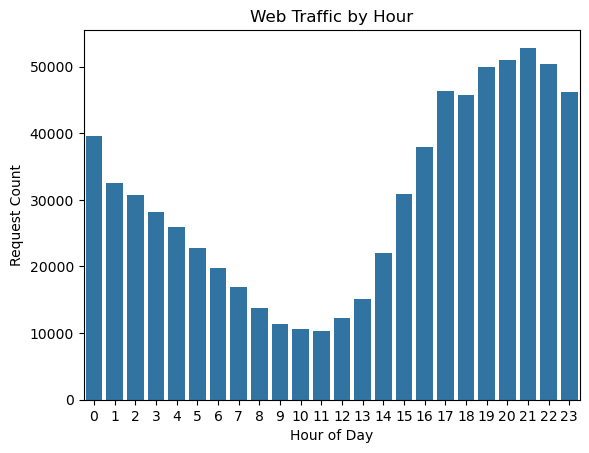

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

sns.countplot(x='hour', data=df)
plt.title('Web Traffic by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Request Count')
plt.show()

### Q2. Daily Traffic Volume

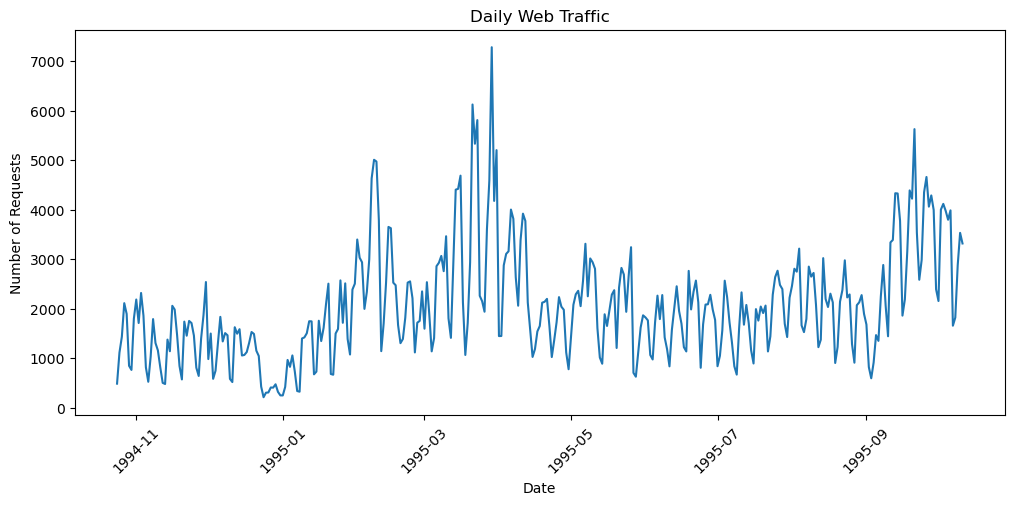

In [70]:
df['date'] = df['timestamp'].dt.date

df_daily = df.groupby('date').size().reset_index(name='request_count')

plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='request_count', data=df_daily)
plt.title('Daily Web Traffic')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45)
plt.show()

### Q3.  Traffic by Weekday

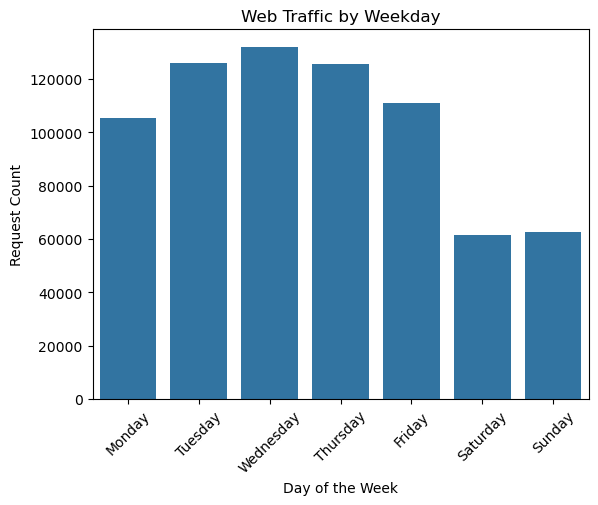

In [95]:
sns.countplot(x='weekday', data=df, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Web Traffic by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Request Count')
plt.xticks(rotation=45)
plt.show()

### Q4. Top Requested Files or Endpoints

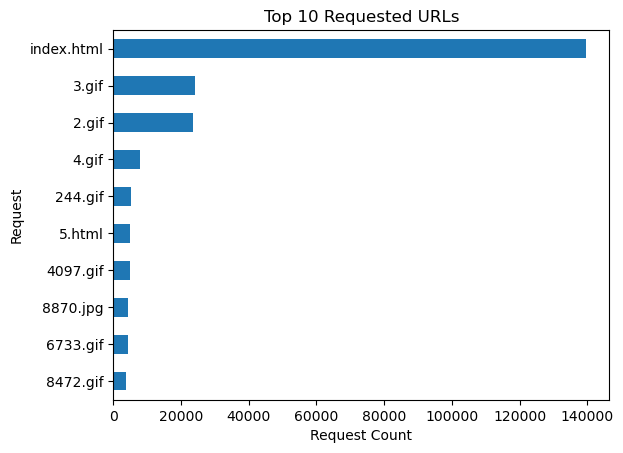

In [87]:
df['request'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Requested URLs')
plt.xlabel('Request Count')
plt.ylabel('Request')
plt.gca().invert_yaxis()
plt.show()

### Q5. Area Plot of Daily Traffic (Cumulative View)

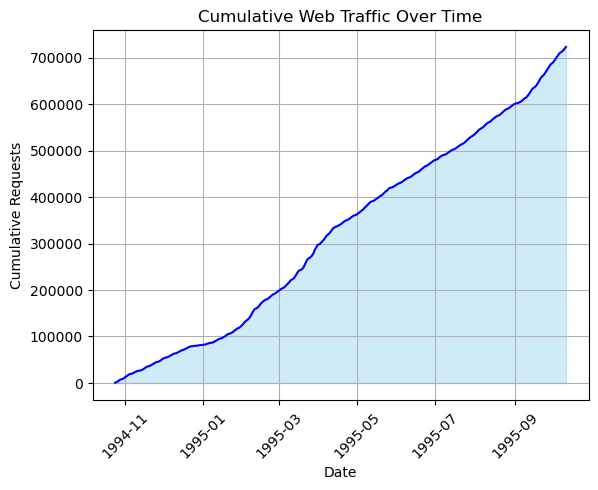

In [97]:
df_cum = df_daily.copy()
df_cum['cumulative'] = df_cum['request_count'].cumsum()

plt.fill_between(df_cum['date'], df_cum['cumulative'], color='skyblue', alpha=0.4)
plt.plot(df_cum['date'], df_cum['cumulative'], color='blue')
plt.title('Cumulative Web Traffic Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Requests')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Q6. Box Plot of Traffic Volume by Weekday.

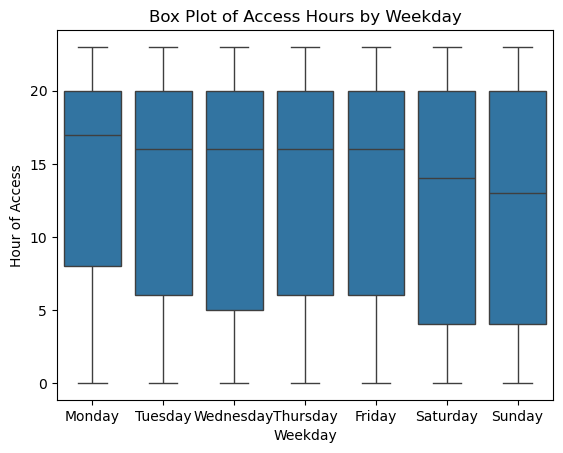

In [105]:
sns.boxplot(x='weekday', y='hour', data=df, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Box Plot of Access Hours by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Hour of Access')
plt.show()

### Q7. sns.kdeplot(df['hour'], fill=True, color='green')

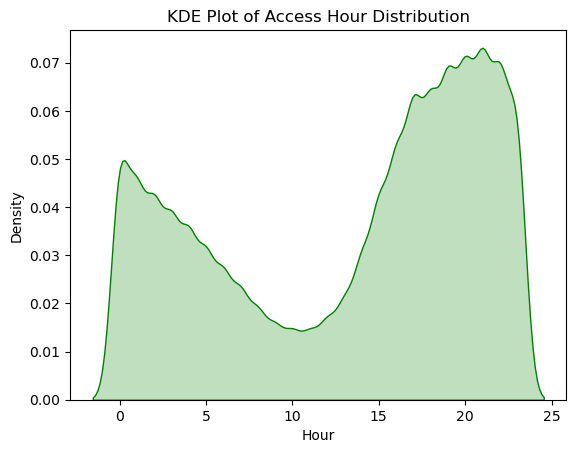

In [113]:
sns.kdeplot(df['hour'], fill=True, color='green')
plt.title('KDE Plot of Access Hour Distribution')
plt.xlabel('Hour')
plt.ylabel('Density')
plt.show()

### Q8. Histogram of Request Volume per IP

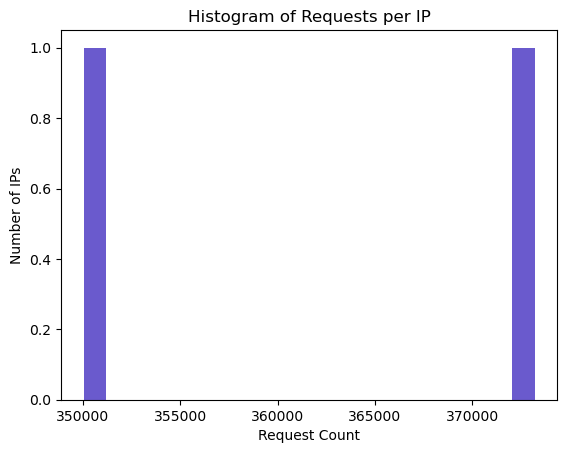

In [117]:
df['host'].value_counts().plot(kind='hist', bins=20, color='slateblue')
plt.title('Histogram of Requests per IP')
plt.xlabel('Request Count')
plt.ylabel('Number of IPs')
plt.show()

### Q9. Scatter Plot: Bytes vs Hour (colored by Status Code)

C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


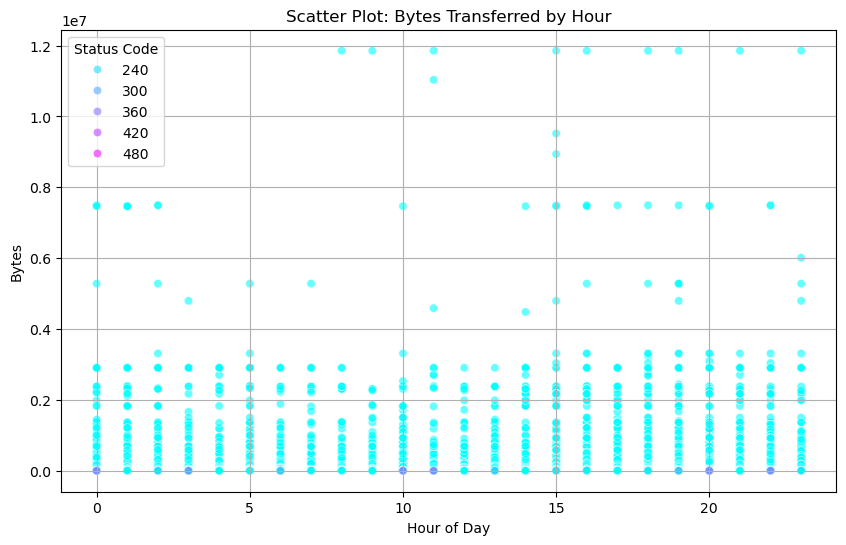

In [120]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='hour', y='bytes', hue='status', data=df, palette='cool', alpha=0.6)
plt.title('Scatter Plot: Bytes Transferred by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Bytes')
plt.legend(title='Status Code')
plt.grid(True)
plt.show()

### Q.10 Bytes Distribution by Status Code.

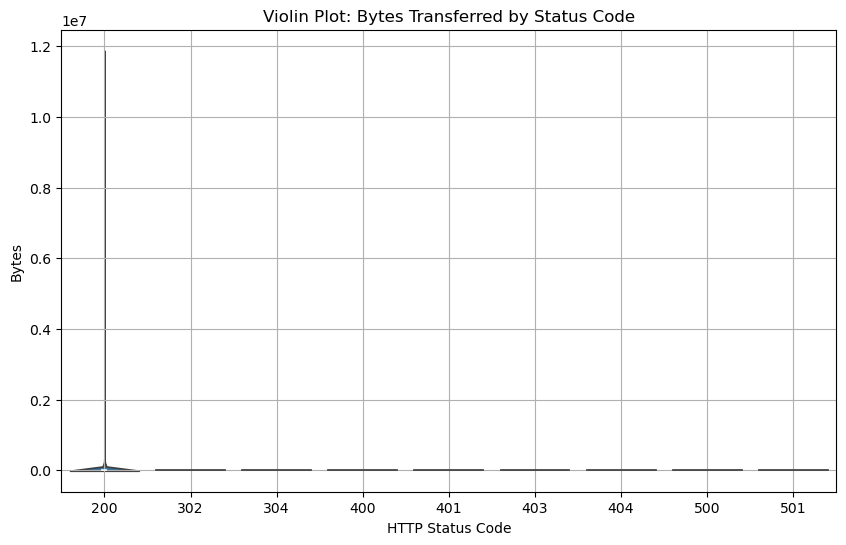

In [125]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='status', y='bytes', data=df, inner='box')
plt.title('Violin Plot: Bytes Transferred by Status Code')
plt.xlabel('HTTP Status Code')
plt.ylabel('Bytes')
plt.grid(True)
plt.show()